#### toy grover search
&nbsp; &nbsp; &nbsp; following Nielsen-Chuang ( chapter 6.1 ) and Hidary ( chapter 8.6 )

In [1]:
import cirq
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def int2bit( n, k ):
    assert n < 2 ** k
    b = [ 0 if b == '0' else 1 for b in bin( n )[ 2 : ] ]
    b = ( k - len( b ) ) * [ 0 ] + b
    return b # the binary expansion of n, as a list of k bits

In [3]:
def bit2int( b ):
    n = sum( [ bn * 2 ** n for n, bn in enumerate( reversed( b ) ) ] )
    return n

In [15]:
def reflection( q ):
    R = [ cirq.Z.controlled( len( q ) - 1 ).on( * q[ : -1 ], q[ -1 ] ) ]
    return R # a gate in a list

In [5]:
def oracle_block( q, m ): # only the oracle knows m
    b = int2bit( m, len( q ) ) # the bits of m
    Xs = [ cirq.X( qn ) for qn, bn in zip( q, b ) if bn == 0 ]
    R = reflection( q )
    return Xs + R + Xs # gates in a list

In [6]:
def diffusion_block( q ):
    Hs = [ cirq.H( qn ) for qn in q ]
    Xs = [ cirq.X( qn ) for qn in q ]
    R = reflection( q )
    return Hs + Xs + R + Xs + Hs # gates in a list

In [7]:
def grover_block( q, oracle ):
    diffuser = diffusion_block( q )
    return oracle + diffuser # gates in a list

In [8]:
def grover_circuit( q, oracle, width ):
    Hs = [ cirq.H( qn ) for qn in q ]
    blocks = width * grover_block( q, oracle )
    measure = [ cirq.measure( qn, key = str( n ) ) for n, qn in enumerate( q ) ]
    circuit = cirq.Circuit( Hs + blocks + measure )
    return circuit

In [9]:
def simulate( q, program, repetitions ):
    result = cirq.Simulator( ).run( program = program, repetitions = repetitions )
    result = [ result.measurements[ str( n ) ] for n in range( len( q ) ) ]
    return np.array( result ).squeeze( )

In [10]:
def plot( measurement, k ):
    count = np.zeros( 2 ** k, dtype = 'float' )
    for n in measurement : count[ n ] += 1
    prob = count / np.sum( count )
    fig, axis = plt.subplots( )
    axis.set_facecolor( 'black' )
    axis.tick_params( colors = 'white' )
    axis.set_xlabel( 'measurement', color = 'white', size = '14' )
    axis.set_ylabel( 'probability', color = 'white', size = '14' )
    axis.plot( range( 2 ** k ), prob, color = 'white', marker = '.', linestyle = 'None' )
    fig.set_figwidth( 11 )
    fig.set_figheight( 6 )
    plt.show( )

In [11]:
def display( circuit, result, width, m ):
    [ k, repetitions ] = result.shape
    w = int( 3.14 / 4 * 2 ** ( k / 2 ) ) 
    measurement = np.array( [ bit2int( result[ : , n ] ) for n in range( repetitions ) ] )
    print( 'grover circuit simulation\n' )
    print( f'qubits        { k }' )
    print( f'optimal width { w } blocks' )
    print( f'actual width  { width } blocks' )
    print( f'looking for   { m } among the numbers { 0 }, { 1 }, ..., { 2 ** k - 1 }\n' )
    if repetitions < 300 : print( f'measurements\n{ measurement }' )
    if k < 20 : plot( measurement, k )
    if width <  3 : print( f'\ncircuit diagram\n{ circuit }' ) 

grover circuit simulation

qubits        5
optimal width 4 blocks
actual width  2 blocks
looking for   6 among the numbers 0, 1, ..., 31

measurements
[ 6  6  6  6  6 18  6  6 20  6  6  6  6 15  6  6 23  6  6  6 14  6  6  6
  6 30  6  6  6 20 13  8  6  6  4  3  4  6  6  6 16  6  6 28  6 21 28  6
  6 29]


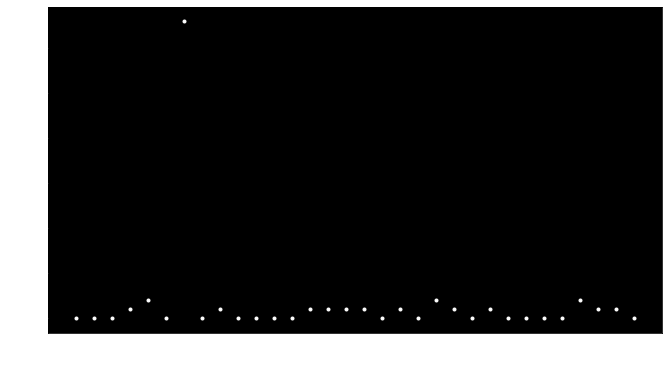


circuit diagram
0: ───H───X───@───X───H───X───@───X───H───X───@───X───H───X───@───X───H───M('0')───
              │               │               │               │
1: ───H───X───@───X───H───X───@───X───H───X───@───X───H───X───@───X───H───M('1')───
              │               │               │               │
2: ───H───────@───H───X───────@───X───H───────@───H───X───────@───X───H───M('2')───
              │               │               │               │
3: ───H───────@───H───X───────@───X───H───────@───H───X───────@───X───H───M('3')───
              │               │               │               │
4: ───H───X───Z───X───H───X───Z───X───H───X───Z───X───H───X───Z───X───H───M('4')───


In [18]:
m = 6 # what we hope to measure
k = 5 # number of qubits
q = cirq.LineQubit.range( k )
oracle = oracle_block( q, m )

w = int( 3.14 / 4 * 2 ** ( k / 2 ) ) # optimal width of the circuit, in blocks
w = 2 # try smaller circuit
grover = grover_circuit( q, oracle, w )

repetitions = 50
result = simulate( q, grover, repetitions )
display( grover, result, w, m )

grover circuit simulation

qubits        16
optimal width 200 blocks
actual width  100 blocks
looking for   11111 among the numbers 0, 1, ..., 65535

measurements
[ 4278 11111 31583 11111 10040 42113 11111 11111  7464 11111 11111 55848
 30646 11111 21540 11111 37909 11111 46691 24338  7286 11111 11111 11111
 24963 63780 11111 33145 11111 46787  5491 11111 11111  5406 31161  1722
 11111 11111 11880  3422 11111 11111 26347 47603 11111  4815 11111  8412
 11111 40430]


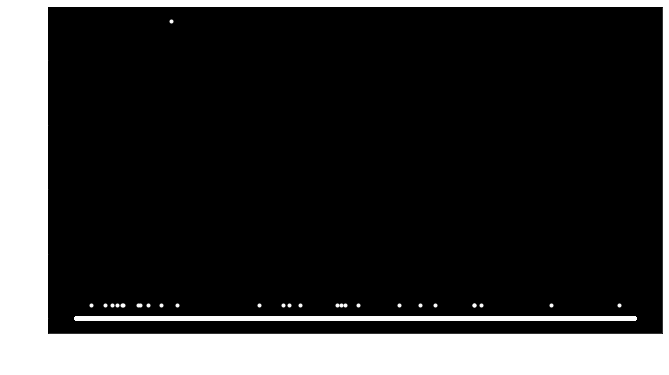

In [14]:
m = 11111 # what we hope to measure
k = 16 # number of qubits
q = cirq.LineQubit.range( k )
oracle = oracle_block( q, m )

w = int( 3.14 / 4 * 2 ** ( k / 2 ) ) # optimal width of the circuit, in blocks
w = 100 # try smaller circuit
grover = grover_circuit( q, oracle, w )

repetitions = 50
result = simulate( q, grover, repetitions )
display( grover, result, w, m )